Train validation data with convnet

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [15]:
data[data['ptl_idx']==1].head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0


In [16]:
test_data = data[data['ptl_idx']==1]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


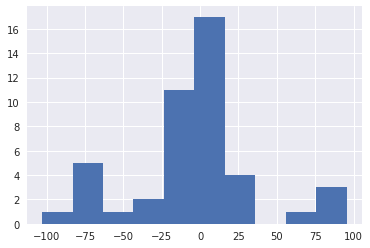

In [17]:
test_data['dt1'].hist()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


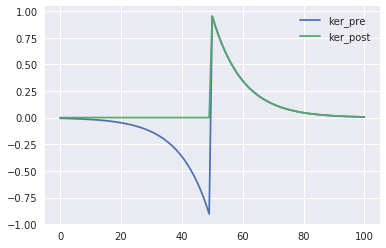

In [18]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()
plt.plot(ker_test.bilat_ker, label='ker_pre')
plt.plot(ker_test.unilat_ker, label='ker_post')
plt.legend()

In [19]:
# Generate data
spk_pairs, targets = arb_w_gen(df=data, ptl_list=[1], kernel=ker_test, spk_len=60000, aug_times=10)

In [20]:
# Create the network
ground_truth_init = 0
toy_data_net = network.PairNet(kernel=ker_test, kernel_pre=ker_test.bilat_ker, kernel_post=ker_test.unilat_ker, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [21]:
# Create the trainer
toy_net_trainer = trainer.Trainer(toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir='/src/Plasticity_Ker/model',  optimizer_config={'learning_rate': toy_data_net.lr})

In [22]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


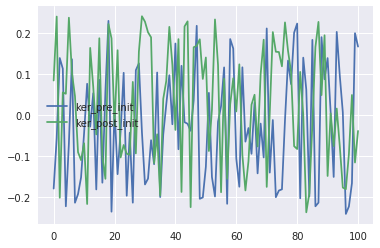

In [23]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(w_pre, label='ker_pre_init')
plt.plot(w_post, label='ker_post_init')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
bias
plt.legend()

In [24]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 3
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3


Initial validation cost=24371.55859
Global Step 0200 and Step 0200: validation cost=3026.67334
Updated min validation loss!Saving model...
Global Step 0400 and Step 0400: validation cost=801.10608
Updated min validation loss!Saving model...


KeyboardInterrupt: 

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


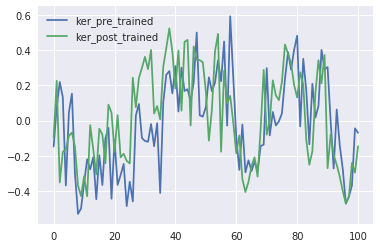

In [25]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(w_pre, label='ker_pre_trained')
plt.plot(w_post, label='ker_post_trained')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
bias
plt.legend()